# **Product Recommendation**
**Subject**: BADS 7105 - CRM Analytics and Intelligence

**Student** : Phannita Thianthammachat 

**ID** : 6310412026


# **Initialization**

In [1]:
# Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install umap-learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

import pandas as pd

# **Data Cleansing**

Skip this, after executing once.

In [4]:
# Load Data
df = pd.read_csv('/content/drive/My Drive/BADS7105 CRM/Final_Work/Prod_Rec.csv')
df.head()

,Timestamp,โปรแกรมแท้,เครื่องซักผ้า,NONE,รองเท้าวิ่ง,ผักกรอบ,คอร์สเรียนเสริม,nintendo switch,BTC (Bitcoin),mechanical keyboard,เครื่องดูดฝุ่น Dyson,เคส ipad,คุณเคยซื้อโต๊ะปรับระดับหรือไม่,สินค้าจากพิมรี่พาย,I PHONE 13,"หูฟัง bluetooth (airpods,truewireless)",แก้วน้ำ Starbucks,เบาะรองนั่ง,เครื่องชงกาแฟแคปซูล,ตั๋วเครื่องบินไปญี่ปุ่น,Ebook,ตู้เย็น,กล้องฟิล์ม,เครื่องดนตรี,whey protein,วัตถุมงคล,กระบองเพชรพูดได้,ROV Skin
0,10/28/2021 14:05,NaN,NaN,NaN,เคยซื้อ,เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคย,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ
1,10/28/2021 14:06,NaN,NaN,NaN,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,เคยซื้อ,เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคย,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ
2,10/28/2021 14:06,NaN,NaN,NaN,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคย,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ
3,10/28/2021 14:06,NaN,NaN,NaN,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,เคยซื้อ,เคย,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ
4,10/28/2021 14:06,NaN,NaN,NaN,เคยซื้อ,เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคย,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ


In [5]:
df.rename(columns={'คุณเคยซื้อโต๊ะปรับระดับหรือไม่':'โต๊ะปรับระดับ'}, inplace=True)
df.rename(columns={'หูฟัง bluetooth (airpods,truewireless)':'หูฟัง bluetooth'}, inplace=True)

In [6]:
# Drop 'Timestamp', 'โปรแกรมแท้', 'เครื่องซักผ้า', 'NONE' column
df = df.drop(['Timestamp', 'โปรแกรมแท้', 'เครื่องซักผ้า', 'NONE'], axis=1).reset_index(drop=True).rename_axis('student').copy()
df.head()

,รองเท้าวิ่ง,ผักกรอบ,คอร์สเรียนเสริม,nintendo switch,BTC (Bitcoin),mechanical keyboard,เครื่องดูดฝุ่น Dyson,เคส ipad,โต๊ะปรับระดับ,สินค้าจากพิมรี่พาย,I PHONE 13,หูฟัง bluetooth,แก้วน้ำ Starbucks,เบาะรองนั่ง,เครื่องชงกาแฟแคปซูล,ตั๋วเครื่องบินไปญี่ปุ่น,Ebook,ตู้เย็น,กล้องฟิล์ม,เครื่องดนตรี,whey protein,วัตถุมงคล,กระบองเพชรพูดได้,ROV Skin
student,,,,,,,,,,,,,,,,,,,,,,,,
0,เคยซื้อ,เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคย,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ
1,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,เคยซื้อ,เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคย,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ
2,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคย,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ
3,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,เคยซื้อ,เคย,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ
4,เคยซื้อ,เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,เคยซื้อ,ไม่เคยซื้อ,ไม่เคย,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ,ไม่เคยซื้อ


In [7]:
# Check unique values
df.melt()['value'].value_counts(dropna=False)

ไม่เคยซื้อ    426
เคยซื้อ       240
ไม่เคย         17
เคย            12
NaN             1
Name: value, dtype: int64

In [8]:
# Fill missing values with the most frequent value 
df = df.fillna(df.mode().iloc[0])

# Check missing value (nan)
df.isna().any().sum()

0

In [9]:
# Encode Convert Categorical Values to Binary (0 and 1)
df.replace({'เคย': 1, 'เคยซื้อ': 1, 'ไม่เคย': 0, 'ไม่เคยซื้อ': 0}, inplace=True)
df.head()

,รองเท้าวิ่ง,ผักกรอบ,คอร์สเรียนเสริม,nintendo switch,BTC (Bitcoin),mechanical keyboard,เครื่องดูดฝุ่น Dyson,เคส ipad,โต๊ะปรับระดับ,สินค้าจากพิมรี่พาย,I PHONE 13,หูฟัง bluetooth,แก้วน้ำ Starbucks,เบาะรองนั่ง,เครื่องชงกาแฟแคปซูล,ตั๋วเครื่องบินไปญี่ปุ่น,Ebook,ตู้เย็น,กล้องฟิล์ม,เครื่องดนตรี,whey protein,วัตถุมงคล,กระบองเพชรพูดได้,ROV Skin
student,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
1,1,0,1,1,1,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1
2,1,0,1,0,1,0,0,1,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0
3,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,1,1,0,1,0,0,0,0
4,1,1,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0


# **Market Basket Analysis**

Associations Rules

In [10]:
# Determine product association using apriori
# Select itemsets with support value greater than or equal to 0.5.

frequent_itemsets = apriori(df, min_support=0.5, use_colnames=True)
frequent_itemsets.head(10).sort_values(by=['support'],ascending=False)

,support,itemsets
0,0.965517,(รองเท้าวิ่ง)
1,0.931034,(คอร์สเรียนเสริม)
2,0.896552,(เคส ipad)
7,0.896552,"(รองเท้าวิ่ง, คอร์สเรียนเสริม)"
8,0.862069,"(รองเท้าวิ่ง, เคส ipad)"
3,0.758621,(หูฟัง bluetooth)
9,0.758621,"(รองเท้าวิ่ง, หูฟัง bluetooth)"
5,0.655172,(Ebook)
4,0.551724,(เบาะรองนั่ง)
6,0.551724,(เครื่องดนตรี)


In [11]:
# List out rules

# Lift > 1 : 2 items occur in transactions together more often than we would expect based on their individual support values. 
# This means the relationship is unlikely to be explained by random chance.
# Select itemsets with lift value greater than or equal to 1.

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head(10).sort_values(by=['lift'],ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(เบาะรองนั่ง),(คอร์สเรียนเสริม),0.551724,0.931034,0.551724,1.000000,1.074074,0.038050,inf
4,(คอร์สเรียนเสริม),(เบาะรองนั่ง),0.931034,0.551724,0.551724,0.592593,1.074074,0.038050,1.100313
0,(รองเท้าวิ่ง),(หูฟัง bluetooth),0.965517,0.758621,0.758621,0.785714,1.035714,0.026159,1.126437
1,(หูฟัง bluetooth),(รองเท้าวิ่ง),0.758621,0.965517,0.758621,1.000000,1.035714,0.026159,inf
2,(รองเท้าวิ่ง),(Ebook),0.965517,0.655172,0.655172,0.678571,1.035714,0.022592,1.072797
3,(Ebook),(รองเท้าวิ่ง),0.655172,0.965517,0.655172,1.000000,1.035714,0.022592,inf
6,(คอร์สเรียนเสริม),(Ebook),0.931034,0.655172,0.620690,0.666667,1.017544,0.010702,1.034483
7,(Ebook),(คอร์สเรียนเสริม),0.655172,0.931034,0.620690,0.947368,1.017544,0.010702,1.310345
9,(เครื่องดนตรี),(คอร์สเรียนเสริม),0.551724,0.931034,0.517241,0.937500,1.006944,0.003567,1.103448
8,(คอร์สเรียนเสริม),(เครื่องดนตรี),0.931034,0.551724,0.517241,0.555556,1.006944,0.003567,1.008621


In [12]:
# Filter rules

# Confidence : probability of seeing the 'consequents' in a transaction given that it also contains the 'antecedents'.
# Select itemsets with lift value greater than or equal to 1 and confidence value greater than or equal to 0.5

rules = rules[ (rules['lift'] >= 1) & (rules['confidence'] >= 0.5) ]
rules.sort_values('lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
54,"(คอร์สเรียนเสริม, เคส ipad)",(เบาะรองนั่ง),0.827586,0.551724,0.551724,0.666667,1.208333,0.095125,1.344828
88,"(คอร์สเรียนเสริม, เคส ipad)","(รองเท้าวิ่ง, เบาะรองนั่ง)",0.827586,0.517241,0.517241,0.625000,1.208333,0.089180,1.287356
87,"(รองเท้าวิ่ง, เบาะรองนั่ง)","(คอร์สเรียนเสริม, เคส ipad)",0.517241,0.827586,0.517241,1.000000,1.208333,0.089180,inf
59,(เบาะรองนั่ง),"(คอร์สเรียนเสริม, เคส ipad)",0.551724,0.827586,0.551724,1.000000,1.208333,0.095125,inf
82,"(รองเท้าวิ่ง, คอร์สเรียนเสริม, เคส ipad)",(เบาะรองนั่ง),0.793103,0.551724,0.517241,0.652174,1.182065,0.079667,1.288793
93,(เบาะรองนั่ง),"(รองเท้าวิ่ง, คอร์สเรียนเสริม, เคส ipad)",0.551724,0.793103,0.517241,0.937500,1.182065,0.079667,3.310345
71,(เครื่องดนตรี),"(คอร์สเรียนเสริม, เคส ipad)",0.551724,0.827586,0.517241,0.937500,1.132813,0.060642,2.758621
66,"(คอร์สเรียนเสริม, เคส ipad)",(เครื่องดนตรี),0.827586,0.551724,0.517241,0.625000,1.132812,0.060642,1.195402
95,"(รองเท้าวิ่ง, คอร์สเรียนเสริม, เคส ipad)",(Ebook),0.793103,0.655172,0.586207,0.739130,1.128146,0.066587,1.321839
106,(Ebook),"(รองเท้าวิ่ง, คอร์สเรียนเสริม, เคส ipad)",0.655172,0.793103,0.586207,0.894737,1.128146,0.066587,1.965517


In [13]:
# Confidence = 1 (maximal) for a rule A->C if the 'consequents' and 'antecedents' always occur together.
# Select itemsets that ensure that when buying 'antecedents' will buy 'consequents'.

ABSOLUTE = rules[rules['confidence'] == 1]
ABSOLUTE.head(100).sort_values(by=['lift'],ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
87,"(รองเท้าวิ่ง, เบาะรองนั่ง)","(คอร์สเรียนเสริม, เคส ipad)",0.517241,0.827586,0.517241,1.0,1.208333,0.089180,inf
59,(เบาะรองนั่ง),"(คอร์สเรียนเสริม, เคส ipad)",0.551724,0.827586,0.551724,1.0,1.208333,0.095125,inf
67,"(คอร์สเรียนเสริม, เครื่องดนตรี)",(เคส ipad),0.517241,0.896552,0.517241,1.0,1.115385,0.053508,inf
13,(เบาะรองนั่ง),(เคส ipad),0.551724,0.896552,0.551724,1.0,1.115385,0.057075,inf
17,(เครื่องดนตรี),(เคส ipad),0.551724,0.896552,0.551724,1.0,1.115385,0.057075,inf
83,"(รองเท้าวิ่ง, คอร์สเรียนเสริม, เบาะรองนั่ง)",(เคส ipad),0.517241,0.896552,0.517241,1.0,1.115385,0.053508,inf
39,"(รองเท้าวิ่ง, เบาะรองนั่ง)",(เคส ipad),0.517241,0.896552,0.517241,1.0,1.115385,0.053508,inf
49,"(รองเท้าวิ่ง, เครื่องดนตรี)",(เคส ipad),0.517241,0.896552,0.517241,1.0,1.115385,0.053508,inf
55,"(คอร์สเรียนเสริม, เบาะรองนั่ง)",(เคส ipad),0.551724,0.896552,0.551724,1.0,1.115385,0.057075,inf
5,(เบาะรองนั่ง),(คอร์สเรียนเสริม),0.551724,0.931034,0.551724,1.0,1.074074,0.038050,inf


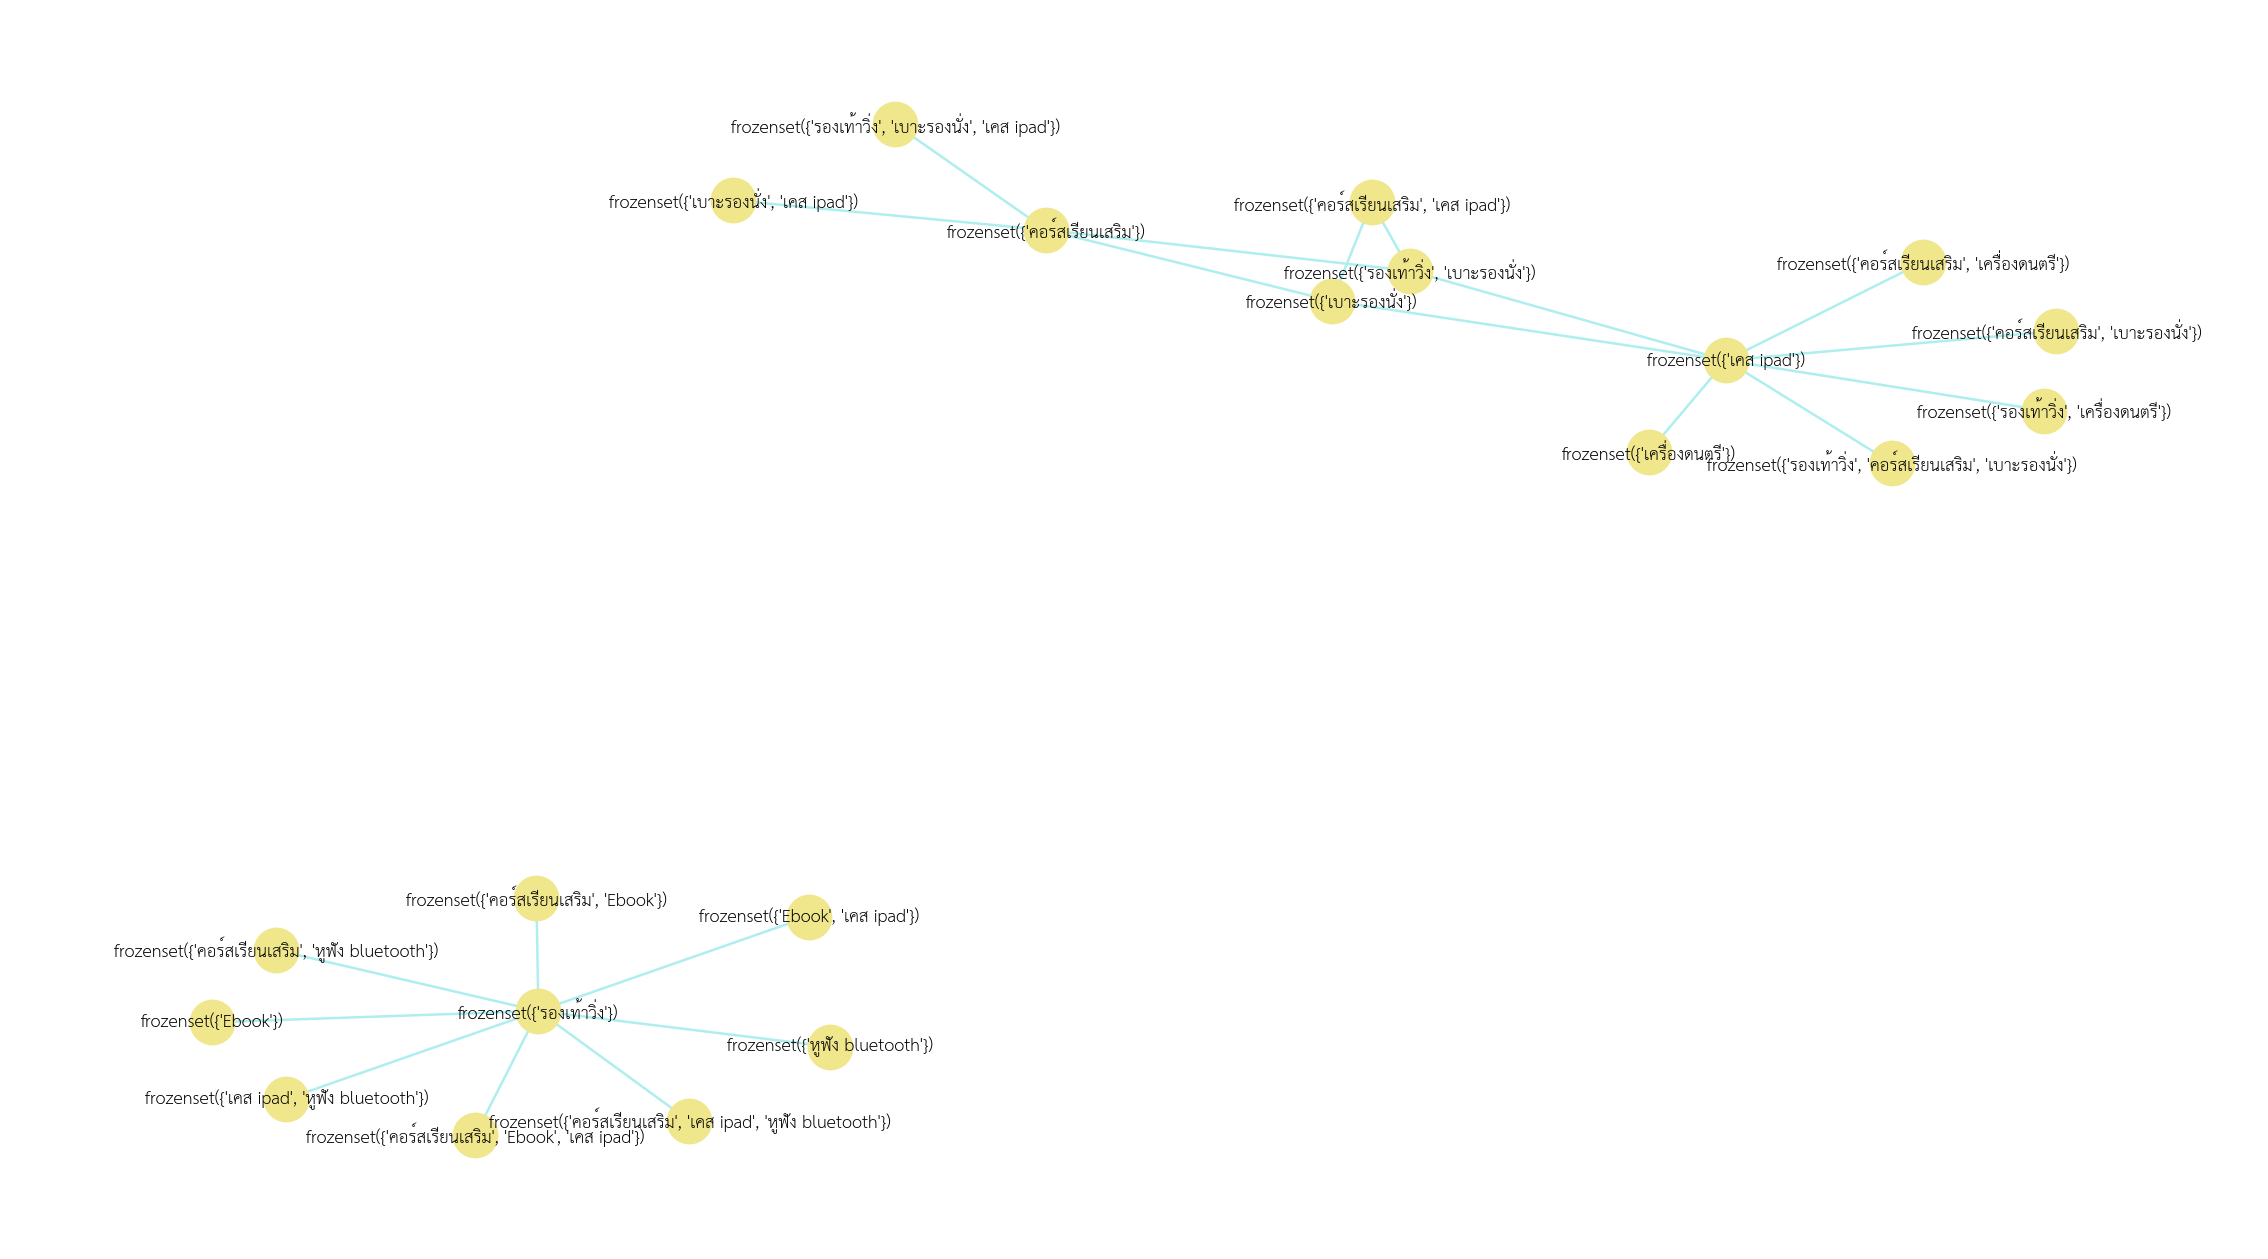

In [42]:
# Visualize rules
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('THSarabunNew.ttf')
mpl.rc('font',family='TH Sarabun New',size=12)
plt.rcParams['font.family'] ='TH Sarabun New'
labels_params = {'font_family': 'TH Sarabun New', 'alpha':1, 'font_size':10, 'font_color':"black",'font_weight':500,'edge_color':'paleturquoise','node_color':'khaki'}

fig, ax=plt.subplots(figsize=[16,9],dpi=180)
GA=nx.from_pandas_edgelist(ABSOLUTE,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True, **labels_params)
plt.show()

# **Collaborative Filtering**

In [15]:
# Prepare data
item_item_matrix = pd.DataFrame(index=df.columns,columns=df.columns)
item_item_matrix.head()

,รองเท้าวิ่ง,ผักกรอบ,คอร์สเรียนเสริม,nintendo switch,BTC (Bitcoin),mechanical keyboard,เครื่องดูดฝุ่น Dyson,เคส ipad,โต๊ะปรับระดับ,สินค้าจากพิมรี่พาย,I PHONE 13,หูฟัง bluetooth,แก้วน้ำ Starbucks,เบาะรองนั่ง,เครื่องชงกาแฟแคปซูล,ตั๋วเครื่องบินไปญี่ปุ่น,Ebook,ตู้เย็น,กล้องฟิล์ม,เครื่องดนตรี,whey protein,วัตถุมงคล,กระบองเพชรพูดได้,ROV Skin
รองเท้าวิ่ง,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ผักกรอบ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
คอร์สเรียนเสริม,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nintendo switch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BTC (Bitcoin),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Calculate cosine similarity
from scipy.spatial.distance import cosine

for i in range(0,len(item_item_matrix.columns)) :
    # Loop through the columns for each column
    for j in range(0,len(item_item_matrix.columns)) :
      # Fill in placeholder with cosine similarities
      item_item_matrix.iloc[i,j] = 1 -cosine(df.iloc[:,i],df.iloc[:,j])

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [17]:
# Convert results into list of rule
links = item_item_matrix.rename_axis('related item', axis='columns').stack().reset_index()
links.columns = ['item', 'related item','value']
links.head(10).sort_values(by=['value'],ascending=False)

,item,related item,value
0,รองเท้าวิ่ง,รองเท้าวิ่ง,1
2,รองเท้าวิ่ง,คอร์สเรียนเสริม,0.945611
7,รองเท้าวิ่ง,เคส ipad,0.926562
4,รองเท้าวิ่ง,BTC (Bitcoin),0.681385
1,รองเท้าวิ่ง,ผักกรอบ,0.597614
3,รองเท้าวิ่ง,nintendo switch,0.5
5,รองเท้าวิ่ง,mechanical keyboard,0.422577
9,รองเท้าวิ่ง,สินค้าจากพิมรี่พาย,0.327327
6,รองเท้าวิ่ง,เครื่องดูดฝุ่น Dyson,0.267261
8,รองเท้าวิ่ง,โต๊ะปรับระดับ,0.188982


In [55]:
# Filter rule
# Filter only pairs with cosine similarity greater than or equal to 0.6

links_filtered=links.loc[ (links['value'] >= 0.6) & (links['item'] != links['related item']) ]
links_filtered.head(10)

,item,related item,value
2,รองเท้าวิ่ง,คอร์สเรียนเสริม,0.945611
4,รองเท้าวิ่ง,BTC (Bitcoin),0.681385
7,รองเท้าวิ่ง,เคส ipad,0.926562
10,รองเท้าวิ่ง,หูฟัง bluetooth,0.886405
12,รองเท้าวิ่ง,เบาะรองนั่ง,0.708683
15,รองเท้าวิ่ง,Ebook,0.823754
16,รองเท้าวิ่ง,ตู้เย็น,0.654654
18,รองเท้าวิ่ง,เครื่องดนตรี,0.708683
25,ผักกรอบ,คอร์สเรียนเสริม,0.608581
46,คอร์สเรียนเสริม,รองเท้าวิ่ง,0.945611


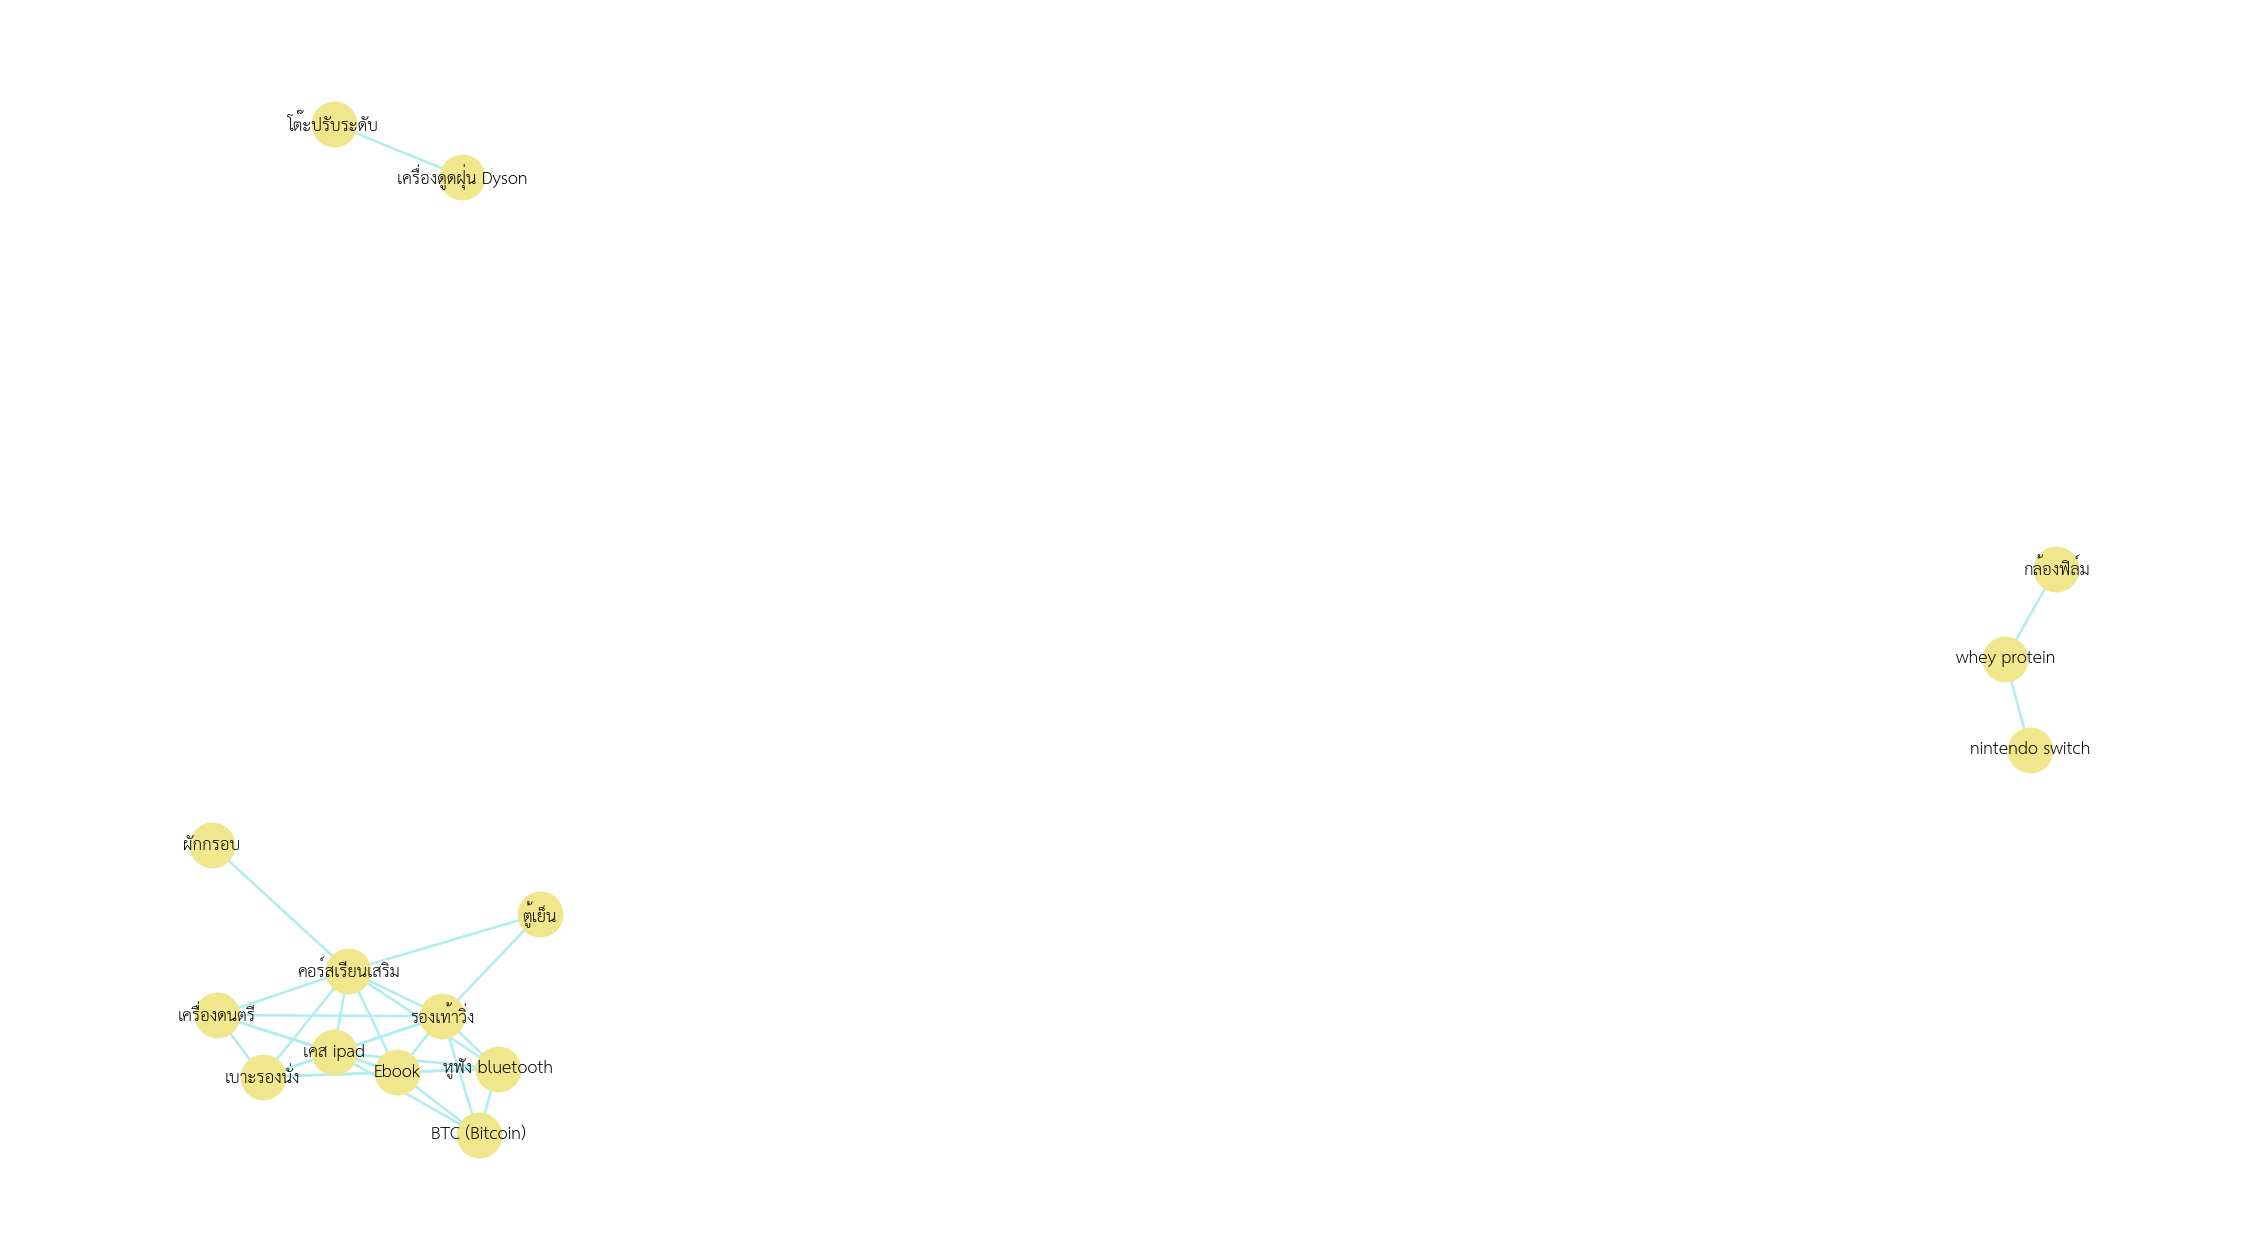

In [59]:
# Visualize rules
fig, ax=plt.subplots(figsize=[16,9],dpi=180)
GA=nx.from_pandas_edgelist(links_filtered,source='item',target='related item')
nx.draw(GA,with_labels=True, **labels_params)
plt.show()